In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import fitsio as ft
import numpy as np

In [2]:
import sys
sys.path.append('/Users/mehdi/github/LSSutils')
from LSSutils import utils, catalogs

camb is not installed!


In [3]:
nside= 128
data = ft.read(f'/Users/mehdi/Dropbox/LRG_density_maps/heapix_map_lrg_ir_nominal_20191024_clean_combined_{nside}.fits', 
               lower=True)
data.dtype.names

('hp_idx',
 'ra',
 'dec',
 'density',
 'pix_frac',
 'ebv',
 'galdepth_gmag',
 'galdepth_rmag',
 'galdepth_zmag',
 'psfdepth_w1mag',
 'psfsize_g',
 'psfsize_r',
 'psfsize_z',
 'stardens_log',
 'region')

In [4]:
data.size

76710

In [5]:
np.unique(data['region'])

array(['bm', 'decals', 'des'], dtype='<U6')

In [6]:
des    = data[data['region'] == 'des']
decals = data[data['region'] == 'decals']

In [7]:
des.size + decals.size

52826

In [9]:
def shiftra(ra):
    return ra - 360 * (ra>300)

8703
44123


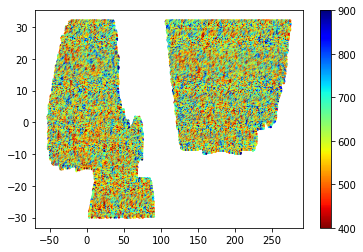

In [10]:
for data_i in [des, decals]:
    print(data_i.size)
    plt.scatter(shiftra(data_i['ra']), data_i['dec'], 1, 
                c=data_i['density'], vmin=400, vmax=900,
                cmap=plt.cm.jet_r)
plt.colorbar()

[[], Text(0.5, 0, 'sqrt(density)')]

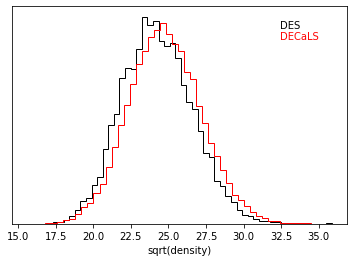

In [89]:
means = []
fig, ax = plt.subplots()
i=0
c=['k', 'r']
for name_i, data_i in zip(['DES', 'DECaLS'],[des, decals]):
    means.append(np.mean(data_i['density']))
    ax.hist(np.sqrt(data_i['density']),  
            density=True,
            #range=(2, 3.5),
            #range=(0, 2000),
            bins=50,
            cumulative=False,
            histtype='step',
            color=c[i])
    ax.text(0.8, 0.9-i*0.05, name_i, 
            transform=ax.transAxes,
           color=c[i])
    i += 1
ax.set(xlabel='sqrt(density)', yticks=[])#, yscale='log')

In [90]:
means[0]/means[1]-1

-0.04129638333198915

In [14]:
from scipy.stats import spearmanr, pearsonr
def PCC(xc, yc, kind='spearman'):
    if not kind in ['pearson', 'spearman']:
        raise ValueError(f'{kind} not defined')
    elif kind == 'pearson':
        func = pearsonr
    elif kind == 'spearman':
        func = spearmanr
        
    pcc = []
    for j in range(xc.shape[1]):
        pcc.append(func(xc[:,j], yc)[0])
    return pcc

def BTPCC(xc, yc, num=100):
    np.random.seed(123456)
    pcc = []
    for _ in range(num):
        pcc.append(PCC(xc, np.random.permutation(yc)))
    return pcc

In [15]:
list_of_cols = ['ebv',
                 'galdepth_gmag',
                 'galdepth_rmag',
                 'galdepth_zmag',
                 'psfdepth_w1mag',
                 'psfsize_g',
                 'psfsize_r',
                 'psfsize_z',
                 'stardens_log']

In [16]:
import pandas as pd

In [23]:
def make_pcc_plot(data, list_of_cols=list_of_cols, figax=None, title='PCC'):
    pd_des = pd.DataFrame(np.array(data).byteswap().newbyteorder())
    templates = pd_des[list_of_cols].values
    pcci = PCC(templates,   pd_des['density'])
    pccs = BTPCC(templates, pd_des['density'])
    prcntiles = np.percentile(pccs, [2, 98], axis=0)
    x = np.arange(len(prcntiles[0]))
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
        
    ax.bar(x, pcci, color='crimson', alpha=0.5)
    ax.fill_between(x, y1=prcntiles[0], 
                   y2=prcntiles[1], alpha=0.2, color='b')
    ax.set_xticks(x)
    ax.grid(True, ls=':', color='grey')
    ax.set_xticklabels(list_of_cols, rotation=90)
    ax.set(ylabel='PCC')
    ax.axhline(0, color='k')
    ax.text(0.1, 0.9, title, transform=ax.transAxes)

ranked correlation coef.

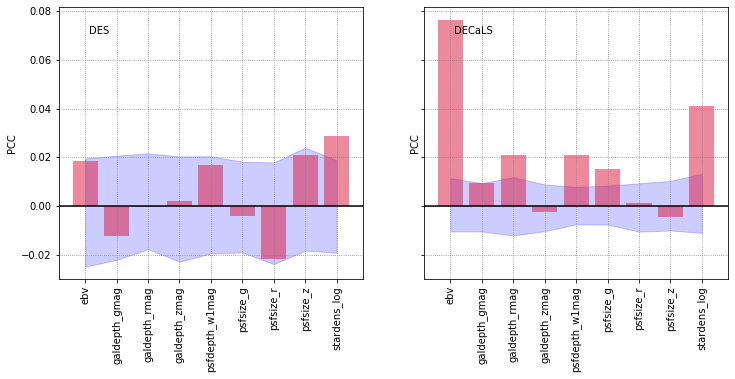

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5),
                              sharey=True)

make_pcc_plot(des, figax=(fig, ax1), title='DES')
make_pcc_plot(decals, figax=(fig, ax2), title='DECaLS')

In [25]:
from LSSutils.stats.nnbar import NNBAR

In [26]:
help(NNBAR)

Help on class NNBAR in module LSSutils.stats.nnbar:

class NNBAR(builtins.object)
 |  NNBAR(galmap, ranmap, mask, sysmap, nbins=20, selection=None, binning='equi-area', verbose=False)
 |  
 |  INPUTS:
 |  galmap, ranmap, mask,
 |  sysmap, bins, selection=None
 |  
 |  Methods defined here:
 |  
 |  __init__(self, galmap, ranmap, mask, sysmap, nbins=20, selection=None, binning='equi-area', verbose=False)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  run(self, njack=20)
 |  
 |  save(self, path4output)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [27]:
np.percentile(des['pix_frac'], [0, 2, 50, 98, 100])

array([0.50001842, 0.80630878, 0.95546156, 1.05430241, 1.1512052 ])

In [28]:
nnbar = {}
for name_i, data_i in zip(['des', 'decals'],
                          [des, decals]):    
    nnbar_i = {}
    for template_i in list_of_cols:
        print(template_i)
        # NNBAR(galmap, ranmap, mask, sysmap, nbins=20, selection=None, binning='equi-area',
        Nnbar_i = NNBAR(data_i['density']*data_i['pix_frac'], 
                        data_i['pix_frac'], np.ones(data_i['pix_frac'].size, '?'),
                       data_i[template_i], nbins=8, binning='equi-area')
        Nnbar_i.run(njack=10)
        nnbar_i[template_i] = Nnbar_i.output
        
    nnbar[name_i] = nnbar_i

ebv
galdepth_gmag
galdepth_rmag
galdepth_zmag
psfdepth_w1mag
psfsize_g
psfsize_r
psfsize_z
stardens_log
ebv
galdepth_gmag
galdepth_rmag
galdepth_zmag
psfdepth_w1mag
psfsize_g
psfsize_r
psfsize_z
stardens_log


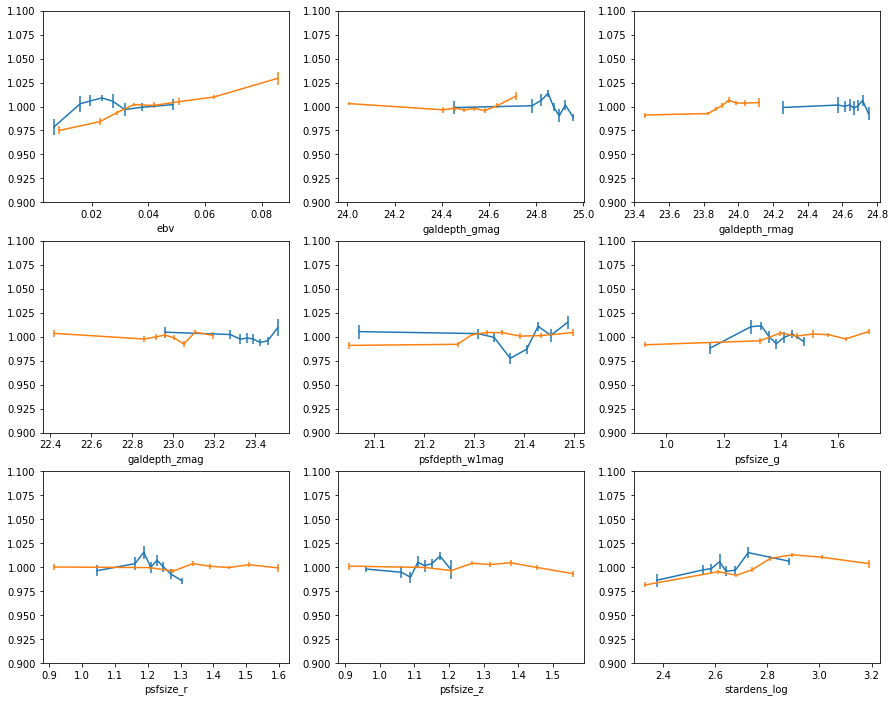

In [29]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(15, 12))
ax = ax.flatten()


for i, name_i in enumerate(nnbar.keys()):
    for j, sys_j in enumerate(list_of_cols):
        ax[j].errorbar(nnbar[name_i][sys_j]['bin_edges'][:-1], 
                       nnbar[name_i][sys_j]['nnbar'],
                       nnbar[name_i][sys_j]['nnbar_err'])
        ax[j].set(ylim=(0.9, 1.1), xlabel=sys_j)

8703
44123


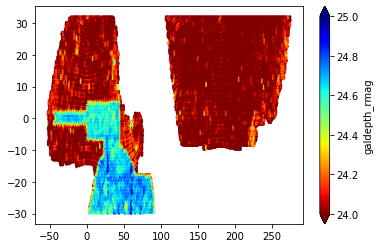

In [10]:
for data_i in [des, decals]:
    print(data_i.size)
    plt.scatter(shiftra(data_i['ra']), data_i['dec'], 1, 
                c=data_i['galdepth_rmag'], vmin=24, vmax=25,
                cmap=plt.cm.jet_r)
plt.colorbar(extend='both', label='galdepth_rmag')

8703 [24.25937271 25.06763268]
44123 [23.4600296  24.87934113]


([], <a list of 0 Text yticklabel objects>)

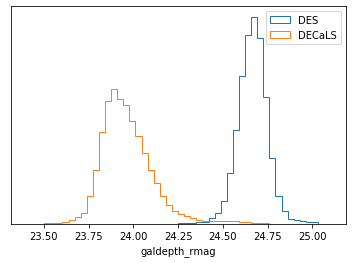

In [24]:
for name_i,data_i in zip(['DES', 'DECaLS'],[des, decals]):
    print(data_i.size, np.percentile(data_i['galdepth_rmag'],[0,100]))
    plt.hist(data_i['galdepth_rmag'], 
             histtype='step', density=True,
            label=name_i,
            range=(23.4, 25.1),
            bins=50)
plt.legend()    
plt.xlabel('galdepth_rmag')
plt.yticks([])
# plt.colorbar(extend='both', label='galdepth_rmag')

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [97]:
decals.size/des.size

5.0698609674824775

In [47]:
desdec = np.concatenate([des, decals[np.random.choice(np.arange(decals.size), 
                                                      replace=False, 
                                                      size=des.size)]])

In [48]:
y = (desdec['region'] == 'des').astype('float64')

In [49]:
x = []
for l in list_of_cols:
    if l == 'ebv':
        print('log of ebv')
        x.append(np.log10(desdec[l]))
    else:
        x.append(desdec[l])
x = np.array(x).T

log of ebv


In [50]:
x.shape, y.shape

((17406, 9), (17406,))

In [51]:
#--- split
xtrain, xtest, ytrain, ytest = train_test_split(x, y)

#--- scale
xmean, xstd = np.mean(xtrain, axis=0), np.std(xtrain, axis=0)
xtrain = (xtrain - xmean)/ xstd
xtest  = (xtest - xmean)/xstd

In [98]:
ytrain.size/ytest.size

2.9995404411764706

In [64]:
logreg = LogisticRegression(solver='lbfgs')
rfe    = RFE(logreg, 2)
rfe    = rfe.fit(xtrain, ytrain)
print(rfe.support_)
print(rfe.ranking_)

[ True False  True False False False False False False]
[1 6 1 7 4 5 8 2 3]


In [65]:
for i,si in enumerate(rfe.support_):
    if si:print(list_of_cols[i])

ebv
galdepth_rmag


In [99]:
list_of_cols

['ebv',
 'galdepth_gmag',
 'galdepth_rmag',
 'galdepth_zmag',
 'psfdepth_w1mag',
 'psfsize_g',
 'psfsize_r',
 'psfsize_z',
 'stardens_log']

In [103]:
ypred = rfe.predict(xtest)

In [55]:
from sklearn.metrics import confusion_matrix

In [104]:
confusion_matrix(ytest, ypred)

array([[2167,   36],
       [   0, 2149]])

In [105]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2203
         1.0       0.98      1.00      0.99      2149

    accuracy                           0.99      4352
   macro avg       0.99      0.99      0.99      4352
weighted avg       0.99      0.99      0.99      4352



In [57]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

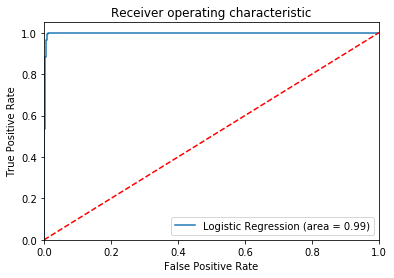

In [68]:
logit_roc_auc = roc_auc_score(ytest, rfe.predict(xtest))
fpr, tpr, thresholds = roc_curve(ytest, rfe.predict_proba(xtest)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [69]:
from sklearn.linear_model import LinearRegression

In [132]:
des_decals = (data['region']=='des') | (data['region']=='decals')

In [134]:
x = np.column_stack([np.log10(data['ebv']), data['galdepth_rmag']])[des_decals]
y = data['density'][des_decals]

In [135]:
x.shape

(52826, 2)

In [136]:
reg = LinearRegression().fit(x, y)

In [137]:
reg.coef_, reg.intercept_

(array([ 44.3036777 , -22.55146832]), 1219.9324513685178)

In [138]:
ypred = reg.predict(x)

52826


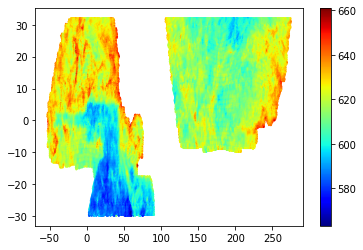

In [140]:
for data_i in [data[des_decals]]:
    print(data_i.size)
    plt.scatter(shiftra(data_i['ra']), data_i['dec'], 1, 
                c=ypred, 
                cmap=plt.cm.jet)
plt.colorbar()

In [153]:
regions = data['region'][des_decals]

([], <a list of 0 Text yticklabel objects>)

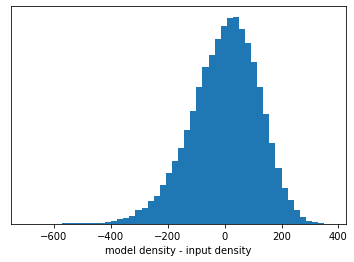

In [150]:
_=plt.hist(ypred - y, bins=50, density=True)
plt.xlabel('model density - input density')
plt.yticks([])

In [144]:
np.sqrt(np.mean((ypred - data['density'][des_decals])**2))

119.57826632221645

In [146]:
np.std(data['density'])

120.79723447907155

In [155]:
regions

array(['decals', 'decals', 'decals', ..., 'des', 'des', 'des'],
      dtype='<U6')

In [154]:
ypred[regions=='des'] / ypred[regions=='decals']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

[[], Text(0.5, 0, 'sqrt(modeled density)')]

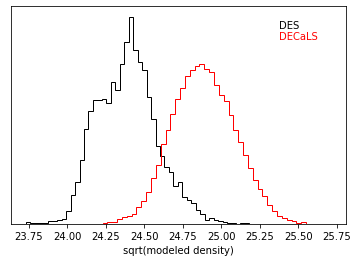

In [159]:
means = []
fig, ax = plt.subplots()
i=0
c=['k', 'r']
for name_i, data_i in zip(['DES', 'DECaLS'],[ypred[regions=='des'] , ypred[regions=='decals']]):
    means.append(np.mean(data_i))
    ax.hist(np.sqrt(data_i),  
            density=True,
            #range=(2, 3.5),
            #range=(0, 2000),
            bins=50,
            cumulative=False,
            histtype='step',
            color=c[i])
    ax.text(0.8, 0.9-i*0.05, name_i, 
            transform=ax.transAxes,
           color=c[i])
    i += 1
ax.set(xlabel='sqrt(modeled density)', yticks=[])#, yscale='log')

In [158]:
means[0]/means[1]-1

-0.039456198562937694

In [160]:
means 

[594.8635965708556, 619.2987718840981]